<b>Vocal-rhythm detection</b>

Data preprocessing step for rap generation project. 

Extracting spectral onset data(and each value) from a rap recording. 
And quantize them into musically meaningful representation. 

In [1]:
%pylab inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
%matplotlib inline

import librosa.display
import IPython.display

import scipy.constants as const
import scipy
from scipy.io import wavfile
# from IPython.core.display import HTML

from __future__ import division



Populating the interactive namespace from numpy and matplotlib


Import the wave file.

In [2]:
# y, sr = librosa.load(librosa.util.example_audio_file(), offset=40, duration=10)
file_name = 'audio/rap.wav'

# y, sr = librosa.load(file_name)

y, sr = librosa.load(file_name,
                     sr=44100,
                     duration=5,
                     offset=35)


In [3]:
y_mono = librosa.core.to_mono(y)
D = librosa.stft(y_mono)


Get the vocal part out of it.

(Or, we get the vocal part out first, then extract percussive part out of it for different result.)

In [4]:
D_harmonic, D_percussive = librosa.decompose.hpss(D)

In [5]:
W_percussive = librosa.core.istft(D_percussive)
W_percussive.shape

(220160,)

let's see how it looks like.

In [6]:
IPython.display.Audio(data=W_percussive, rate=sr)

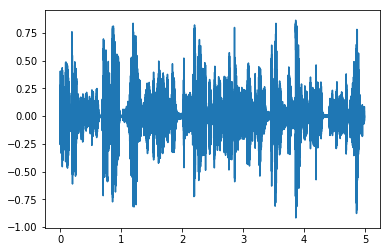

In [7]:
# W_percussive_time = librosa.frames_to_time(W_percussive, sr=sr)
sample_time = librosa.samples_to_time(np.arange(len(W_percussive)), sr=sr)
plt.plot(sample_time, W_percussive)

In [8]:
# using percussive part to extract vocal 

S_full, phase = librosa.magphase(librosa.stft(W_percussive))
S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))
S_filter = np.minimum(S_full, S_filter)
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

In [9]:
W_vocal = librosa.core.istft(S_foreground)

In [10]:
IPython.display.Audio(data=W_vocal, rate=sr)

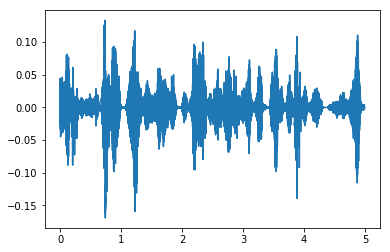

In [11]:
sample_time = librosa.samples_to_time(np.arange(len(W_vocal)), sr=sr)
plt.plot(sample_time, W_vocal)

Here, we could try 2 additional processes to get vocal audio data extracted solely.
(Not implemented yet)

1. Removing certain frequency band of kick drum manually.

2. Due to our prior knowledge that vocal tracks are usually centered while all other instrumental tracks are not, we invert one side track and subtract it to another to get our instrumental track. (Do this for each side.) Then we invert and subtract our resulting left and right side instrumental track to the original track to hopefully get only vocal track left out.



Now, let's get the main beats of the song.

In [12]:
tempo, beats = librosa.beat.beat_track(y=y_mono, sr=sr, units='samples')

In [13]:
beats

array([  9728,  24576,  38400,  52736,  68096,  82432,  97792, 112640,
       126976, 141824, 156672, 171008, 185856, 200704])

In [14]:
beats = beats[::2]
print(beats)

[  9728  38400  68096  97792 126976 156672 185856]


In [15]:
D_percussive.shape

(1025, 431)

In [16]:
W_percussive = librosa.core.istft(D_percussive)
W_percussive.shape

(220160,)

In [17]:
y.shape

(220500,)

Time to get the onset values.

I modified the onset detection code from librosa. (saved as onset_detect_fn.py)
1. added class to import ndarray data into wave class object.
2. function to record values on each onset and return as a list.

In [18]:
from onset_detect_fn import *

In [19]:
w = Wav_nd(W_vocal, sr)
# w.normalize()
# w.downmix()
# w.attenuate(args.att)
s = Spectrogram(w)
# s.log(args.mul, args.add)

# sodf = SpectralODF(s, args.ratio, args.frames)
sodf = SpectralODF(s)
# odf = 'sd'
odf = 'sf'
act = getattr(sodf, odf)()
# o = Onsets(act, args.fps, args.online)
o = Onsets(act, fps=200)

o.detect(threshold = 0.5)



In [20]:
len(o.detections_values)

55

In [21]:
len(o.detections)

55

In [22]:
onset_time = o.detections

In [23]:
onset_values = o.detections_values

In [24]:
onset_log_values = np.asarray([np.log(1 + x) for x in onset_values])

onset_log_values = onset_log_values / np.max(onset_log_values)

# a2 = [x * 3 for x in a1] 
# multiply(S,P)
# SP = P*np.array(S)


In [25]:
onset_log_values.shape

(55,)

In [26]:
onset_samples = librosa.time_to_samples(onset_time, sr=sr)

In [27]:
onset_samples

array([  8158,   9702,  16096,  18522,  21609,  23152,  26019,  30428,
        31972,  37705,  48069,  49612,  51156,  52699,  54684,  61078,
        62622,  69016,  70560,  80703,  82246,  88640,  90404,  95035,
        96358, 103855, 108706, 110911, 117967, 119290, 122377, 126346,
       132300, 134725, 137151, 142443, 143986, 151924, 153247, 155452,
       164272, 169785, 171990, 173754, 181471, 183015, 184999, 186543,
       194701, 199111, 203301, 206608, 209475, 211018, 213884])

In [28]:
onset_array = np.array((onset_time, onset_log_values)).T

In [29]:
onset_array_sample = np.array((onset_samples, onset_log_values)).T

(0, 5)

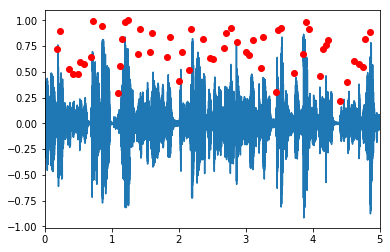

In [30]:
# W_percussive_time = librosa.frames_to_time(W_percussive, sr=sr)
sample_time = librosa.samples_to_time(np.arange(len(W_percussive)), sr=sr)
plt.plot(sample_time, W_percussive)

plt.plot(onset_array[:, 0], onset_array[:, 1], 'ro')
plt.xlim(0, 5)

In [31]:
tempo, beats = librosa.beat.beat_track(y=W_percussive, sr=sr)

In [32]:
hop_length = 512
beats_sample = librosa.frames_to_samples(beats,hop_length=hop_length)

(0, 5)

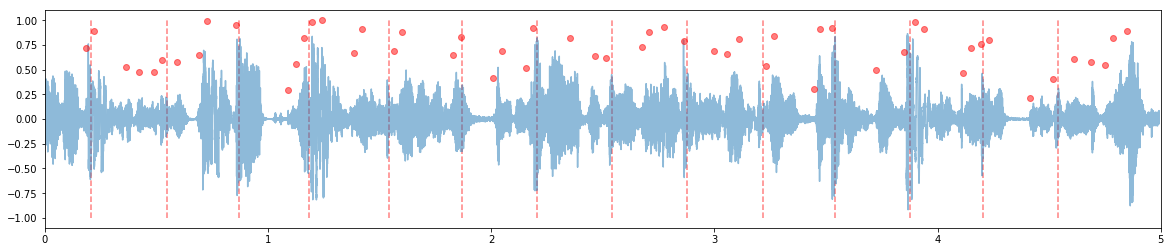

In [33]:
plt.figure(figsize=(20,4))
sample_time = librosa.samples_to_time(np.arange(len(W_percussive)), sr=sr)
# hop_length = 512
# times = librosa.frames_to_time(np.arange(len(W_percussive)), hop_length=hop_length)
plt.plot(sample_time, W_percussive, alpha=0.5)
plt.plot(onset_array[:, 0], onset_array[:, 1], 'ro', alpha=0.5)
plt.vlines(sample_time[beats_sample], -1, 1, alpha=0.5, color='r', linestyle='--', label='Beats')
plt.xlim(0, 5)


In [34]:
beats_sample

array([  9216,  24064,  38400,  52224,  68096,  82432,  97280, 112128,
       126976, 141824, 156160, 171008, 185344, 200192])

Now, time to quantize our data.

I split one measure into 32 ticks, and locate each onset value to the nearest tick.
Any doubling onsets will leave only the larger value.


In [35]:
n = 64

def get_ticks(start_sample, end_sample, n = n):
    ticks = []
    length = end_sample - start_sample
    tick = int(length / n)
    for i in range(0, n):
        ticks.append(start_sample + i * tick)
    return ticks

ticks_list = []

for i in range(0, beats_sample.shape[0]-1):
    ticks = get_ticks(beats_sample[i], beats_sample[i+1])
    ticks_list.append(ticks)
    


In [36]:
print(ticks_list[0][-2])
print(ticks_list[0][-1])
print(ticks_list[1][0])
print(ticks_list[1][1])
print(ticks_list[-1][-1])

23600
23832
24064
24288
199960


In [37]:
all_ticks = np.ndarray.flatten(np.array(ticks_list))

In [38]:
all_ticks.shape


(832,)

In [39]:
beats_sample

array([  9216,  24064,  38400,  52224,  68096,  82432,  97280, 112128,
       126976, 141824, 156160, 171008, 185344, 200192])

In [40]:
n = 64
rhythm_list= []

def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

for i in range(0, beats_sample.shape[0]-1):
    rhythm = np.zeros(n)
    length = beats_sample[i] - beats_sample[i+1]
    tick = length / n
    for onset in onset_array_sample:
#         print(onset)
        ticks_in_this_measure = all_ticks[n*i:n*(i+1)]
#         print(len(ticks_in_this_measure))

        nearest_idx_among_ticks = find_nearest(ticks_in_this_measure, onset[0])
#         print(ticks_in_this_measure[nearest_idx_among_ticks])
        if onset[1] > rhythm[nearest_idx_among_ticks]:
            rhythm[nearest_idx_among_ticks] = onset[1]

    rhythm_list.append(rhythm)

# print(rhythm_list)                                            
                                            

(0, 840)

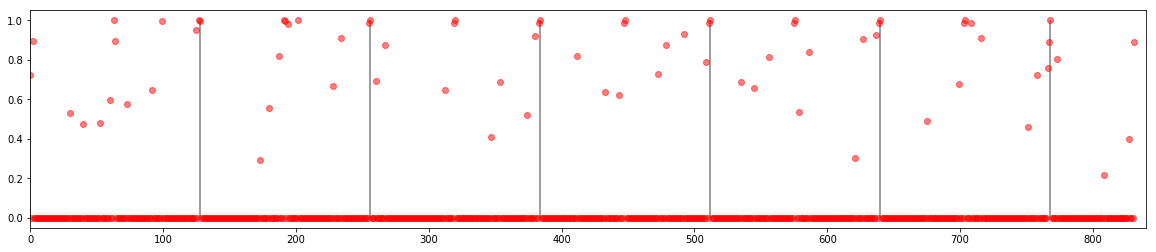

In [41]:
# plt.plot(np.arange(n), rhythm_list[0], 'ro', alpha=0.5)
plt.figure(figsize=(20,4))
plt.plot(np.concatenate(rhythm_list, axis=0), 'ro', alpha=0.5)
l = range(len(rhythm_list)*n)

plt.vlines(l[0::128], 0, 1, alpha=0.5)
plt.xlim(0, 840)

In [42]:
IPython.display.Audio(data=W_percussive, rate=sr)
# need to reorganize the ticks for more expressive musical term.

(0, 5)

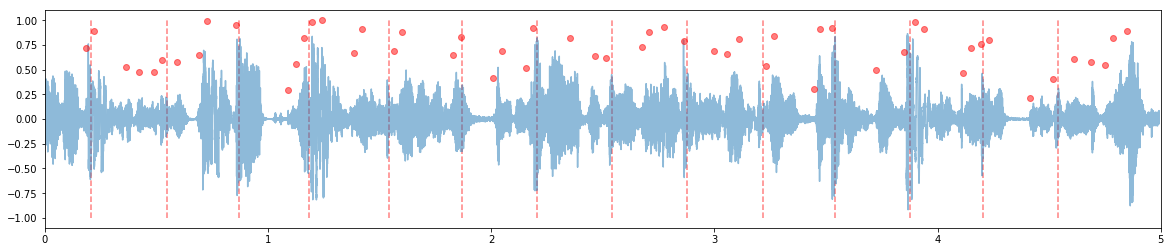

In [43]:
plt.figure(figsize=(20,4))
sample_time = librosa.samples_to_time(np.arange(len(W_percussive)), sr=sr)
# hop_length = 512
# times = librosa.frames_to_time(np.arange(len(W_percussive)), hop_length=hop_length)
plt.plot(sample_time, W_percussive, alpha=0.5)
plt.plot(onset_array[:, 0], onset_array[:, 1], 'ro', alpha=0.5)
plt.vlines(sample_time[beats_sample], -1, 1, alpha=0.5, color='r', linestyle='--', label='Beats')
plt.xlim(0, 5)